In [1]:
import json
import timeit
import numpy as np
import geopandas as gpd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from utils import *


## Load in vector grid data

In [2]:
land_grid = gpd.read_file('../../data/land_grid.json')
ne_land = gpd.read_file('../../data/ne_10m_land/ne_10m_land.shp')


## Load in raster data

In [3]:
name = 'tavg'
# name = 'precip'

if name == 'tavg':
    cmap = "RdBu_r"
    colormap = cm.RdBu_r
    raster = load_tavg_data()
    
elif name == 'precip':
    cmap = 'Blues'
    colormap = cm.Blues
    raster = load_precip_data()

else:
    print('Dataset not yet supported')


In [4]:
raster


<xarray.DataArray 'tavg' (band: 1, y: 1080, x: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * x            (x) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
  * y            (y) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
    spatial_ref  int64 ...
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  34.009499740601
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -45.884000024796
    STATISTICS_STDDEV:   nan

In [5]:
num_cells = raster.shape[1] * raster.shape[2]
print(f"Total number of cells:               {num_cells}")

num_nan_cells = np.sum(np.isnan(raster.data))
print(f"Total number of cells without value: {num_nan_cells}")


Total number of cells:               2332800
Total number of cells without value: 1524747


In [6]:
min_value = raster.min(skipna=True).data
max_value = raster.max(skipna=True).data
print(min_value, max_value)


-45.884 34.0095


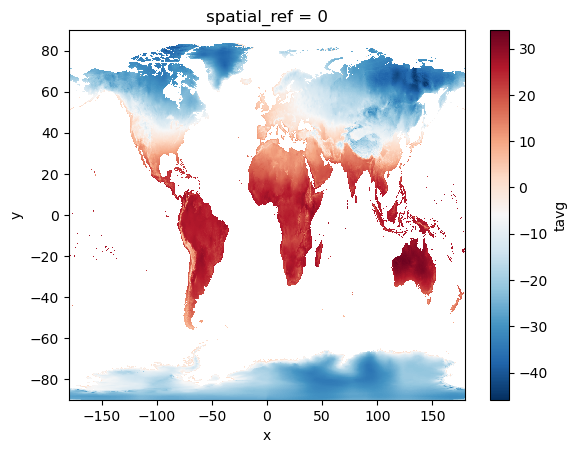

In [7]:
raster.plot(cmap=cmap, vmin=min_value, vmax=max_value)
plt.show()


## Creating the burned raster

In [8]:
land_grid["polygon_id"] = land_grid.index.values
gdf_stats = raster_burn(land_grid, raster)
gdf_stats.reset_index(drop=True, inplace=True)
gdf_stats


Number of missing polygons: 
0
Time to complete: 195.40547s


,id,tavg_value,geometry
0,110,-25.803125,"POLYGON ((-180.00000 71.66667, -179.83333 71.6..."
1,111,-25.652000,"POLYGON ((-180.00000 71.50000, -179.83333 71.5..."
2,112,-25.138000,"POLYGON ((-180.00000 71.33333, -179.83333 71.3..."
3,113,-24.265749,"POLYGON ((-180.00000 71.16667, -179.83333 71.1..."
4,114,-21.429688,"POLYGON ((-180.00000 71.00000, -179.83333 71.0..."
...,...,...,...
805192,2324808,26.750000,"POLYGON ((178.66667 -18.00000, 178.83333 -18.0..."
805193,1165859,NaN,"POLYGON ((-0.16667 0.16667, -0.00000 0.16667, ..."
805194,1165860,NaN,"POLYGON ((-0.16667 0.00000, -0.00000 0.00000, ..."
805195,1166939,NaN,"POLYGON ((0.00000 0.16667, 0.16667 0.16667, 0...."


In [9]:
min_mean, max_mean = gdf_stats[name + "_value"].min(), gdf_stats[name + "_value"].max()
print(min_mean, max_mean)


-45.88399887084961 34.009498596191406


Now let's see how the original raster data compares with our new vector dataset.

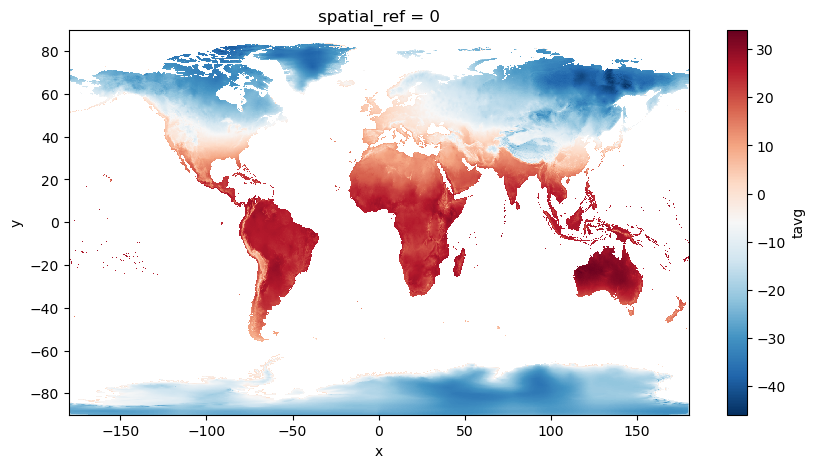

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
raster.plot(cmap=cmap, vmin=min_value, vmax=max_value, ax=ax)
plt.show()


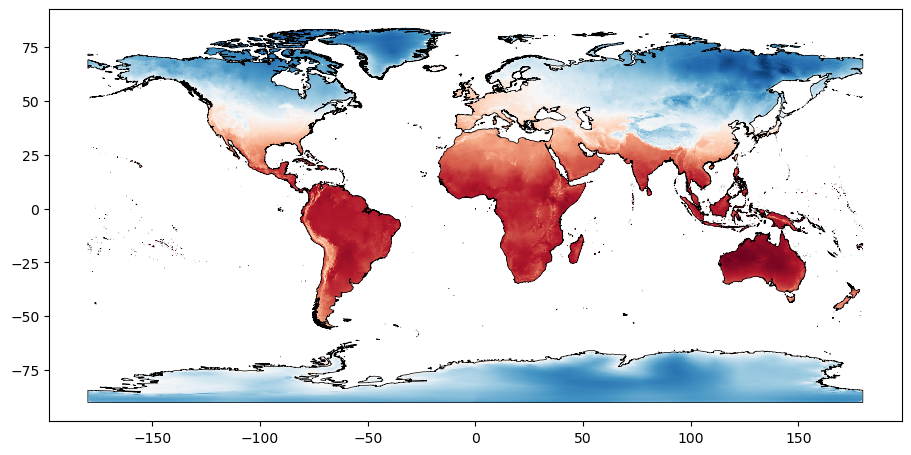

In [11]:
fig, ax = plt.subplots(figsize=(11, 7))
gdf_stats.plot(column=name + "_value", cmap=cmap, vmin=min_value, vmax=max_value, ax=ax)
ne_land.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)
plt.show()


## Creating a colormap for future use


In [13]:
norm = cm.colors.Normalize(vmin=min_mean, vmax=max_mean)
gdf_stats[name + '_color'] = gdf_stats.apply(lambda row: rgba2hex(row[name + "_value"], norm, colormap), axis = 1)
gdf_stats.head()


,id,tavg_value,geometry,tavg_color
0,110,-25.803125,"POLYGON ((-180.00000 71.66667, -179.83333 71.6...",#6bacd0
1,111,-25.652000,"POLYGON ((-180.00000 71.50000, -179.83333 71.5...",#6bacd0
2,112,-25.138000,"POLYGON ((-180.00000 71.33333, -179.83333 71.3...",#71b0d2
3,113,-24.265749,"POLYGON ((-180.00000 71.16667, -179.83333 71.1...",#7ab6d6
4,114,-21.429688,"POLYGON ((-180.00000 71.00000, -179.83333 71.0...",#95c6df


Let's inspect the new colormap.

In [16]:
# order columns before saving
gdf_stats = gdf_stats[['id', name + '_value', name + '_color', 'geometry']]
gdf_stats


,id,tavg_value,tavg_color,geometry
0,110,-25.803125,#6bacd0,"POLYGON ((-180.00000 71.66667, -179.83333 71.6..."
1,111,-25.652000,#6bacd0,"POLYGON ((-180.00000 71.50000, -179.83333 71.5..."
2,112,-25.138000,#71b0d2,"POLYGON ((-180.00000 71.33333, -179.83333 71.3..."
3,113,-24.265749,#7ab6d6,"POLYGON ((-180.00000 71.16667, -179.83333 71.1..."
4,114,-21.429688,#95c6df,"POLYGON ((-180.00000 71.00000, -179.83333 71.0..."
...,...,...,...,...
805192,2324808,26.750000,#aa1529,"POLYGON ((178.66667 -18.00000, 178.83333 -18.0..."
805193,1165859,NaN,#000000,"POLYGON ((-0.16667 0.16667, -0.00000 0.16667, ..."
805194,1165860,NaN,#000000,"POLYGON ((-0.16667 0.00000, -0.00000 0.00000, ..."
805195,1166939,NaN,#000000,"POLYGON ((0.00000 0.16667, 0.16667 0.16667, 0...."


In [17]:
# gdf_stats.to_file(f'../../data/{name}_vec2raster_ne.gpkg', driver='GPKG', layer=f'{name}_vec2raster_ne') 
# with open(f"../../data/{name}_vec2raster_ne.json", "w") as file:
#   file.write(gdf_stats.to_json())


We can do the same process for our precipitation data.